In [262]:
#coding:utf-8

In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from WindPy import *
import copy

In [264]:
w.start()
a=w.wsi("NI1701.SHF", "pct_chg,oi,open,high,low,volume,close", "2013-01-01 00:00:00", "2016-10-20 23:59:59", "")
data=pd.DataFrame()
data['time']=a.Times
for i in range(len(a.Fields)):

    data[a.Fields[i]]=a.Data[i]
w.stop()
data['time']=pd.to_datetime(data['time'])

data['Date']=data['time'].apply(lambda x:str(x.date()) if x.hour<=17 else np.nan)
data=data.sort(['time'])
data['Date']=data['Date'].fillna(method='bfill')
data['Date']=pd.to_datetime(data['Date'])
data=data.dropna(subset=['Date','position','open','volume','close'])

Welcome to use Wind Quant API for Python (WindPy)!
You can use w.menu to help yourself to create commands(WSD,WSS,WST,WSI,WSQ,...)!

COPYRIGHT (C) 2016 WIND HONGHUI INFORMATION & TECHKNOLEWDGE CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [265]:
Ni_data=pd.read_csv('C:\\Users\\liyuefanxxl\\Documents\\gtja\\SHFE_Crawler_Project\\all_data.csv',encoding='gbk')

In [266]:
Ni_data=Ni_data.drop('12',axis=1)

In [267]:
Ni_data=Ni_data.drop_duplicates()

In [268]:
Ni_data['update_date']=pd.to_datetime(Ni_data['update_date'])

Ni_data_1701=Ni_data[Ni_data['name']=='ni1701']

Ni_sum_data=pd.DataFrame()

Ni_sum_data['buy_chg']=Ni_data_1701.groupby('update_date').hold_vol_buy_chg.sum()
Ni_sum_data['sell_chg']=Ni_data_1701.groupby('update_date').hold_vol_sell_chg.sum()

Ni_sum_data=Ni_sum_data.reset_index()

Ni_sum_data['update_date']=Ni_sum_data['update_date'].apply(lambda x: x+np.timedelta64(1,"D"))

Ni_sum_data.index=[Ni_sum_data['update_date']]

Ni_sum_data=Ni_sum_data.drop('update_date',axis=1)

Ni_sum_data['buy_dir']=Ni_sum_data['buy_chg'].apply(lambda x:1 if x>0 else -1)
Ni_sum_data['sell_dir']=Ni_sum_data['sell_chg'].apply(lambda x:-1 if x<0 else 1)

Ni_sum_data['signal']=Ni_sum_data['buy_dir']-Ni_sum_data['sell_dir']

Ni_sum_data_filtered=Ni_sum_data[Ni_sum_data['signal']!=0]

Ni_sum_data_filtered['signal']=Ni_sum_data_filtered['signal']/2

In [280]:
Ni_sum_data_filtered

,buy_chg,sell_chg,buy_dir,sell_dir,signal
update_date,,,,,
2016-05-04,-402.0,114.0,-1,1,-1.0
2016-05-18,-61.0,184.0,-1,1,-1.0
2016-05-19,-16.0,219.0,-1,1,-1.0
2016-05-21,-65.0,256.0,-1,1,-1.0
2016-05-25,-82.0,212.0,-1,1,-1.0
2016-06-01,-321.0,604.0,-1,1,-1.0
2016-06-15,-61.0,482.0,-1,1,-1.0
2016-06-18,395.0,-7.0,1,-1,1.0
2016-07-07,1549.0,-3769.0,1,-1,1.0


In [281]:
daily_price=[]
return_data=copy.deepcopy(data)
for i,j in return_data.groupby('Date'):
    j=j.sort(['time'])
    j_1=j.head(5)
    p=np.dot(j_1['close'],j_1['volume'].T)/np.sum(j_1['volume'])
    temp=[i,p]
    daily_price.append(temp)
daily_P=pd.DataFrame(daily_price)

daily_P=daily_P.rename(columns={0:'Date',1:'Price'})

daily_P['Return']=np.nan
daily_P['Return'][1:]=np.diff(np.log(daily_P['Price']))

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [282]:
daily_P.index=[daily_P['Date']]

In [283]:
daily_P=daily_P.drop('Date',axis=1)

In [284]:
daily_P=daily_P.dropna(axis=0)

In [285]:
daily_P=pd.concat([daily_P,Ni_sum_data_filtered],axis=1,join='inner')

In [286]:
daily_P['result']=daily_P['Return']*daily_P['signal']

In [287]:
daily_P['result'].sum()

-0.02652533905783727

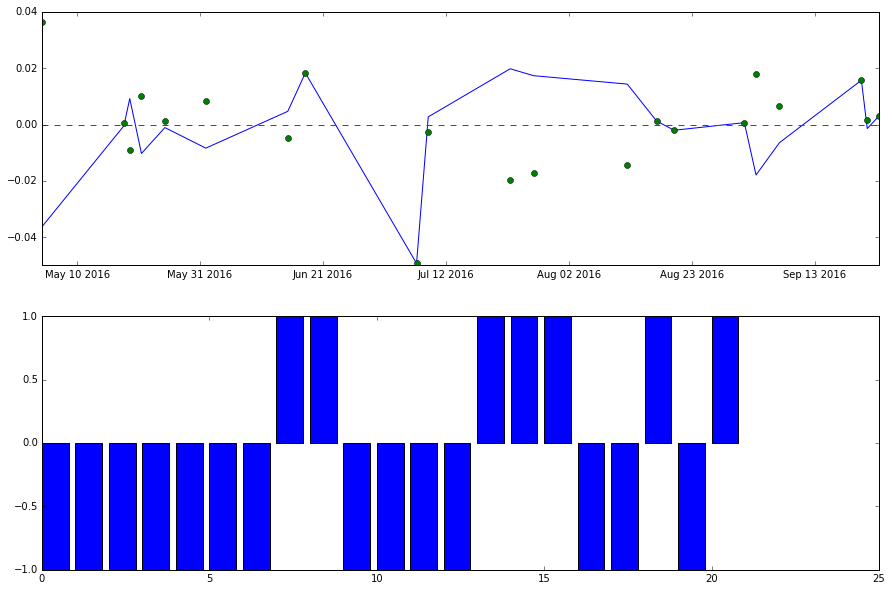

In [288]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(daily_P['result']);
plt.plot(daily_P.index,np.zeros(len(daily_P)),'r--',)
plt.plot(daily_P['Return'],'go');
#plt.plot(daily_P.index,np.zeros(len(daily_P)),'r--',)
plt.subplot(2,1,2)
plt.bar(np.arange(len(daily_P)),daily_P['signal']);

In [289]:
daily_P['accu_rate']=daily_P['Return']*daily_P['signal']

In [290]:
daily_P['accu_rate']=daily_P['accu_rate'].apply(lambda x: 1 if x>0 else 0)

In [291]:
daily_P['accu_rate'].sum()/float(len(daily_P))

0.5238095238095238

In [292]:
w.start()
a=w.wsd("NI1701.SHF", "open,high,low,close", "2016-01-01", "2016-10-23", "")
data=pd.DataFrame()
data['time']=a.Times
for i in range(len(a.Fields)):

    data[a.Fields[i]]=a.Data[i]
w.stop()
data['time']=pd.to_datetime(data['time'])

data['Date']=data['time'].apply(lambda x:str(x.date()) if x.hour<=17 else np.nan)
data=data.sort(['time'])
data['Date']=data['Date'].fillna(method='bfill')
data['Date']=pd.to_datetime(data['Date'])
data=data.dropna(subset=['Date','OPEN','HIGH','LOW','CLOSE'])

Welcome to use Wind Quant API for Python (WindPy)!
You can use w.menu to help yourself to create commands(WSD,WSS,WST,WSI,WSQ,...)!

COPYRIGHT (C) 2016 WIND HONGHUI INFORMATION & TECHKNOLEWDGE CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [293]:
data.index=[data['Date']]

In [294]:
daily_P=daily_P.reset_index()
daily_P=daily_P.rename(columns={'index':'Date'})

In [297]:
daily_P.index=daily_P['Date']

In [299]:
final=pd.concat([daily_P,data],axis=1,join='outer')

In [304]:
final=final.drop('Date',axis=1)

In [306]:
final=final.reset_index()

In [307]:
final.to_csv("daily_P.csv",index=False)